# Human PBMC Integration

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.chdir("/home/mohsen/projects/scarches/")

In [2]:
import scarches as sca
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, facecolor='white')

In [3]:
condition_key = "study"
cell_type_key = 'CellType'
target_conditions = ["Batch2_10X 5\'"]

## Loading data

In [4]:
adata = sc.read("/home/mohsen/data/PBMC/Human_PBMC/human_pbmc_normalized_hvg.h5ad")
adata

AnnData object with n_obs × n_vars = 15476 × 4000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'study', 'size_factors'
    uns: 'CellType_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [10]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

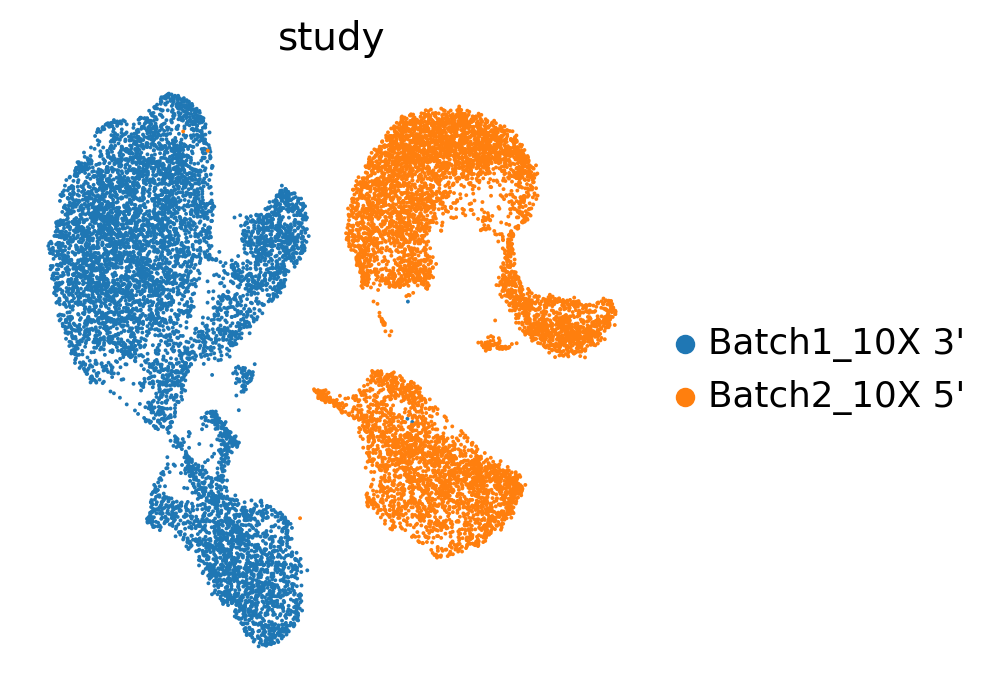

In [11]:
sc.pl.umap(adata, color=[condition_key], frameon=False)

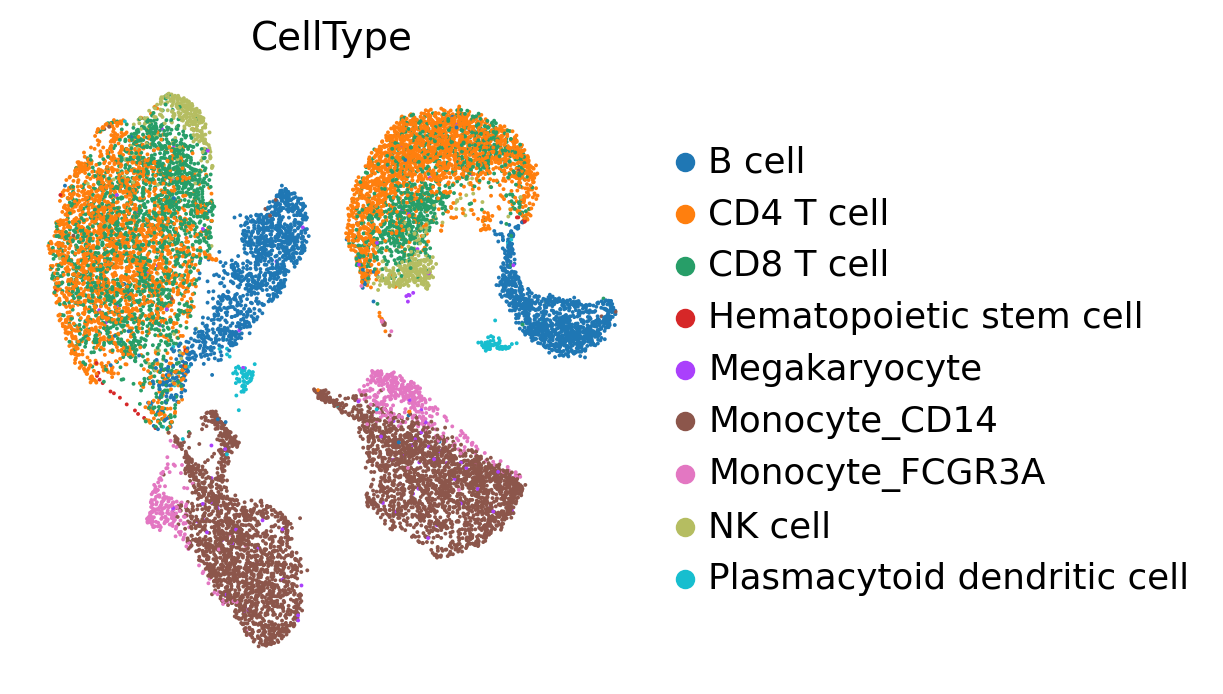

In [12]:
sc.pl.umap(adata, color=[cell_type_key], frameon=False)

## Now we separate query(target) and reference(source) datasets

In [5]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata

View of AnnData object with n_obs × n_vars = 8098 × 4000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'study', 'size_factors'
    uns: 'CellType_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
target_adata

View of AnnData object with n_obs × n_vars = 7378 × 4000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'study', 'size_factors'
    uns: 'CellType_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

## Calculate number of studies (batches)

In [7]:
source_conditions = source_adata.obs[condition_key].unique().tolist()

## Create an instance of scArches model

In [8]:
network = sca.models.scArches(task_name='hpbmc_reference',
                              x_dimension=adata.shape[1], 
                              z_dimension=10,
                              architecture=[128, 128],
                              gene_names=adata.var_names.tolist(),
                              conditions=source_conditions,
                              alpha=0.0002,
                              eta=50.,
                              device='gpu',
                              use_batchnorm=True,
                              loss_fn='mse',
                              model_path="./models/CVAE/MSE/",
                              dropout_rate=0.1,
                              )

Start running on gpu...
CVAE's network has been successfully constructed!
CVAE's network has been successfully compiled!


## Train scArches

You can train scArches with `train` function with the following parameters:

1. __adata__: Annotated dataset used for training and evaluating scArches.
2. __train_size__: Fraction of adata used for training. The rest will be used for validation.
3. __condition_key__: name of the column in `obs` matrix in `adata` which contains the conditions for each sample.
4. __n_epochs__: number of epochs used to train scArches.
5. __batch_size__: number of sample used to sample as mini-batches in order to optmize scArches. 
6. __save__: whether to save scArches' model and configs after training phase or not. 
7. __retrain__: if `False` and scArches' pretrained model exists in `model_path`, will restore scArches' weights. Otherwise will train and validate scArches on `adata`. 

In [9]:
network.train(source_adata,
              train_size=0.9,
              condition_key=condition_key,
              n_epochs=300,
              batch_size=64,
              early_stop_limit=10,
              lr_reducer=7,
              save=True,
              )

 |████████████████████| 100.0%  - loss: 3.4002 - kl_loss: 11.4714 - mse_loss: 0.0680 - val_loss: 3.5084 - val_kl_loss: 11.7223 - val_mse_loss: 0.0701

CVAE has been successfully saved in ./models/CVAE/MSE/hpbmc_reference.


## architecture Surgery (scArches)
In order to perform Architecture surgery on pre-trained scArches model, `operate` function is available with the following arguments:

1. __network__: pre-trained scArches object.
2. __new_task_name__: name of the task you want to solve (related to query atlas you have)
3. __new_conditions__: list of (unique) new studies.
4. __version__: version of scArches you want to use. Must be one of "scArches", "scArches v1", or "scArches v2".

In [13]:
new_network = sca.operate(network,
                          new_task_name="hpbmc_query",
                          new_conditions=target_conditions,
                          version='scArches',
                          )

Start running on gpu...
CVAE's network has been successfully constructed!
CVAE's network has been successfully compiled!
CVAE's network has been successfully compiled!


## Train with query datasets

In [14]:
new_network.train(target_adata,
                  condition_key=condition_key,
                  n_epochs=150,
                  batch_size=32, 
                  early_stop_limit=15, 
                  lr_reducer=10,
                  save=True,
                 )

 |███████████████████-| 97.3%  - loss: 4.5596 - kl_loss: 12.4639 - mse_loss: 0.0911 - val_loss: 4.5064 - val_kl_loss: 12.0166 - val_mse_loss: 0.0901
CVAE has been successfully saved in ./models/CVAE/MSE/hpbmc_query.


## Project query+reference data in to the latent space

In [15]:
latent_adata = new_network.get_latent(adata, condition_key)
latent_adata

AnnData object with n_obs × n_vars = 15476 × 10
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'study', 'size_factors'

In [16]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

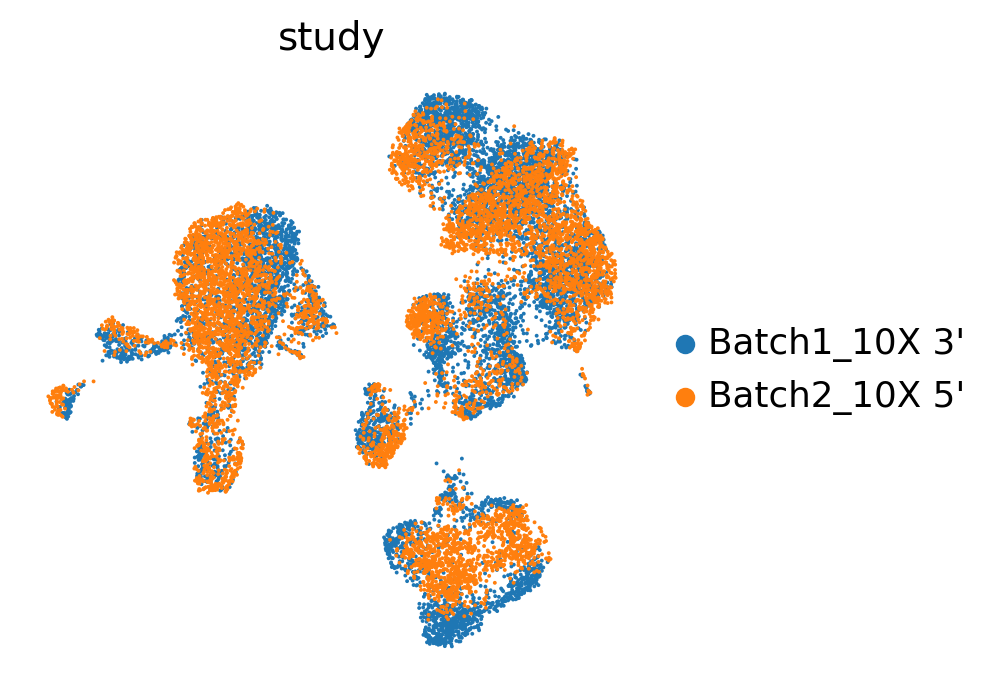

In [15]:
sc.pl.umap(latent_adata, color=[condition_key], 
           wspace=0.5, frameon=False)

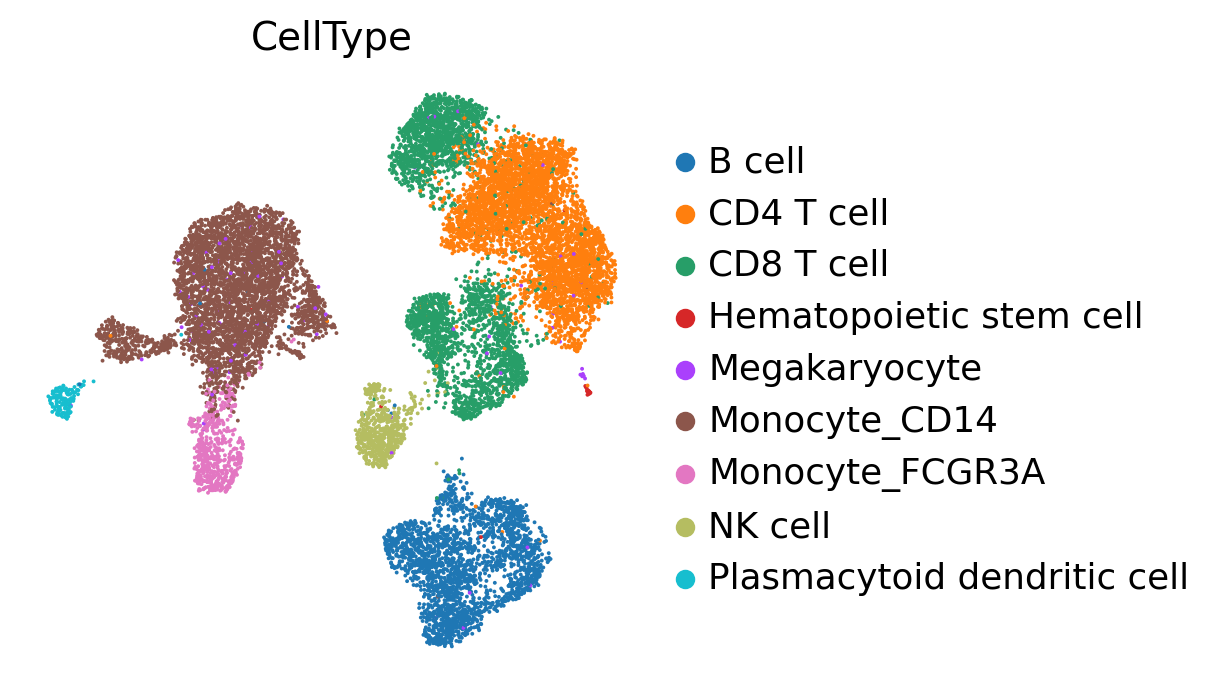

In [16]:
sc.pl.umap(latent_adata, color=[cell_type_key], 
           wspace=0.5, frameon=False)